In [ ]:
# default_exp predict

# predict

> Wrap all components of making rule set 3 predictions into one function

In [ ]:
# export
import pandas as pd
import warnings

from rs3.seq import predict_seq
from rs3.targetdata import (build_translation_overlap_df,
                            build_transcript_aa_seq_df,
                            build_conservation_df)
from rs3.targetfeat import (add_target_columns,
                            get_aa_subseq_df,
                            get_protein_domain_features,
                            get_conservation_features)
from rs3.predicttarg import predict_target

In [ ]:
from rs3.targetdata import write_transcript_data, write_conservation_data

In [ ]:
design_df = pd.read_table('test_data/sgrna-designs.txt')
sanger_activity = pd.read_csv('test_data/Behan2019_activity.csv')
gecko_activity = pd.read_csv('test_data/Aguirre2016_activity.csv')
import multiprocessing
max_n_jobs = multiprocessing.cpu_count()

In [ ]:
# export
from pandas.api.types import is_list_like

def predict_seq_tracr(design_df, tracr, context_col, ref_tracrs, n_jobs):
    if not tracr in ref_tracrs:
        raise ValueError('tracrRNA must be one of ' + ','.join(ref_tracrs))
    design_df['RS3 Sequence Score (' + tracr + ' tracr)'] = predict_seq(design_df[context_col], sequence_tracr=tracr,
                                                                        n_jobs=n_jobs)

def combine_target_seq_scores(design_df, tracr, target_score_col, lite):
    full_rs_name = 'RS3 Sequence (' + tracr + ' tracr) + Target Score'
    if lite:
        full_rs_name += 'Lite'
    design_df[full_rs_name] = \
        design_df['RS3 Sequence Score (' + tracr + ' tracr)'] + \
        design_df[target_score_col]

def predict(design_df, tracr=None, target=False,
            aa_seq_file=None, domain_file=None,
            conservatin_file=None,
            id_cols=None,
            context_col='sgRNA Context Sequence',
            transcript_id_col='Target Transcript',
            transcript_base_col='Transcript Base',
            transcript_len_col='Target Total Length',
            n_jobs_min=1, n_jobs_max=1, lite=True):
    """Make predictions using RS3

    :param design_df: DataFrame
    :param tracr: str or list
    :param target: bool, whether to include target scores
    :param aa_seq_file: str, path to precomputed amino acid sequences
    :param domain_file: str, path to precomputed domain file
    :param id_cols: list or None
    :param context_col: str
    :param transcript_id_col: str
    :param transcript_base_col: str
    :param transcript_len_col: str
    :param n_jobs_min: int
    :return: DataFram
    """
    if id_cols is None:
        id_cols = ['sgRNA Context Sequence', 'Target Cut Length', 'Target Transcript', 'Orientation']
    out_df = design_df.copy()
    ref_tracrs = ['Hsu2013', 'Chen2013']
    if type(tracr) is str:
        predict_seq_tracr(out_df, tracr, context_col, ref_tracrs, n_jobs=n_jobs_max)
    elif is_list_like(tracr):
        for t in tracr:
            predict_seq_tracr(out_df, t, context_col, ref_tracrs, n_jobs=n_jobs_max)
    else:
        raise ValueError('Could not recognize tracr input: ' + str(tracr))
    if target:
        out_df = add_target_columns(out_df,
                                    transcript_base_col=transcript_base_col)
        transcript_bases = pd.Series(out_df[transcript_base_col].unique())
        if aa_seq_file is None:
            aa_seq_df = build_transcript_aa_seq_df(out_df,
                                                   transcript_id_col=transcript_id_col,
                                                   transcript_len_col=transcript_len_col,
                                                   n_jobs=n_jobs_min)
        else:
            aa_seq_df = pd.read_parquet(aa_seq_file, engine='pyarrow',
                                        filters=[[(transcript_base_col, 'in', transcript_bases)]])
        missing_transcripts_aa = transcript_bases[~transcript_bases.isin(aa_seq_df[transcript_base_col])]
        if len(missing_transcripts_aa) > 0:
            warnings.warn('Missing amino acid sequences for transcripts: ' +
                          ','.join(missing_transcripts_aa))
            out_df['Missing translation information'] = out_df[transcript_base_col].isin(missing_transcripts_aa)
        aa_subseq_df = get_aa_subseq_df(sg_designs=out_df, aa_seq_df=aa_seq_df, width=16,
                                        id_cols=id_cols)
        if lite:
            target_score_col = 'Target Score Lite'
            out_df[target_score_col] = predict_target(design_df=out_df, aa_subseq_df=aa_subseq_df,
                                                      id_cols=id_cols)
        else:
            if domain_file is None:
                domain_df = build_translation_overlap_df(aa_seq_df['id'].unique(), n_jobs=n_jobs_min)
            else:
                domain_df = pd.read_parquet(domain_file, engine='pyarrow',
                                            filters=[[(transcript_base_col, 'in', transcript_bases)]])
                # No warning for domain, since some transcripts aren't annotated with any domains
            domain_feature_df = get_protein_domain_features(out_df, domain_df,
                                                           id_cols=id_cols, transcript_base_col=transcript_base_col)
            if conservatin_file is None:
                conservation_df = build_conservation_df(out_df, n_jobs=n_jobs_max)
            else:
                conservation_df = pd.read_parquet(conservatin_file, engine='pyarrow',
                                                  filters=[[(transcript_base_col, 'in', transcript_bases)]])
            missing_transcripts_cons = transcript_bases[~transcript_bases.isin(conservation_df[transcript_base_col])]
            if len(missing_transcripts_cons) > 0:
                warnings.warn('Missing conservation scores for transcripts: ' +
                              ','.join(missing_transcripts_cons))
            out_df['Missing conservation information'] = out_df[transcript_base_col].isin(missing_transcripts_cons)
            conservation_feature_df = get_conservation_features(out_df, conservation_df,
                                                                small_width=2, large_width=16,
                                                                conservation_column='ranked_conservation',
                                                                id_cols=id_cols)
            target_score_col = 'Target Score'
            out_df[target_score_col] = predict_target(design_df=out_df, aa_subseq_df=aa_subseq_df,
                                                      domain_feature_df=domain_feature_df,
                                                      conservation_feature_df=conservation_feature_df,
                                                      id_cols=id_cols)
        if type(tracr) is str:
            combine_target_seq_scores(out_df, tracr, target_score_col, lite)
        else: # list
            for t in tracr:
                combine_target_seq_scores(out_df, t, target_score_col, lite)
    return out_df

In [ ]:
scored_designs = predict(design_df, tracr=['Hsu2013', 'Chen2013'], target=True,
                         n_jobs_min=2, n_jobs_max=max_n_jobs,
                         lite=False)

Calculating sequence-based features


100%|██████████| 400/400 [00:04<00:00, 85.01it/s] 


Calculating sequence-based features


100%|██████████| 400/400 [00:00<00:00, 2471.62it/s]


Getting amino acid sequences


100%|██████████| 4/4 [00:08<00:00,  2.25s/it]


Getting protein domains


100%|██████████| 200/200 [00:59<00:00,  3.35it/s]


Getting conservation


100%|██████████| 200/200 [03:36<00:00,  1.08s/it]
/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [ ]:
write_transcript_data(design_df, n_jobs=2,
                      filepath='./data/target_data/',
                      aa_seq_name='aa_seqs.pq',
                      protein_domain_name='protein_domains.pq')

Getting amino acid sequences


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Getting protein domains


100%|██████████| 200/200 [01:00<00:00,  3.30it/s]


In [ ]:
write_conservation_data(design_df, n_jobs=max_n_jobs,
                        filepath='./data/target_data/',
                        cons_file_name='conservation.pq')

Getting conservation


100%|██████████| 200/200 [03:35<00:00,  1.08s/it]


In [ ]:
scored_designs_stored = predict(design_df, tracr=['Hsu2013', 'Chen2013'], target=True,
                                n_jobs_min=2, n_jobs_max=max_n_jobs,
                                aa_seq_file='./data/target_data/aa_seqs.pq',
                                domain_file='./data/target_data/protein_domains.pq',
                                conservatin_file='./data/target_data/conservation.pq',
                                lite=False)
pd.testing.assert_frame_equal(scored_designs, scored_designs_stored)

Calculating sequence-based features


100%|██████████| 400/400 [00:00<00:00, 628.94it/s]


Calculating sequence-based features


100%|██████████| 400/400 [00:00<00:00, 2256.05it/s]
/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [ ]:
activity_id_cols = ['sgRNA Sequence', 'sgRNA Context Sequence',
                    'Target Gene Symbol', 'Target Cut %']
sanger_actvity_scores = (sanger_activity.merge(scored_designs_stored,
                                               how='inner',
                                               on=activity_id_cols))
gecko_activity_scores = (gecko_activity.merge(scored_designs_stored,
                                              how='inner',
                                              on=activity_id_cols))


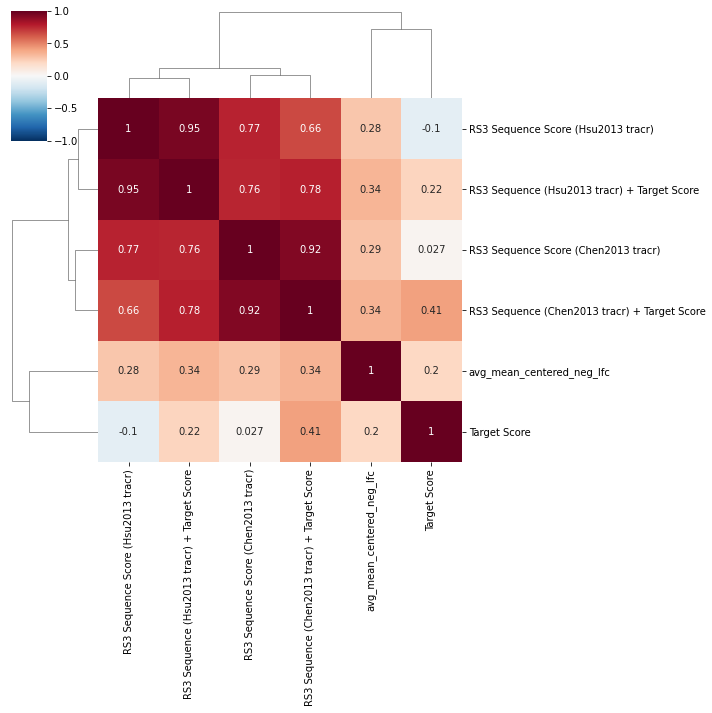

In [ ]:
import seaborn as sns
activity_col = 'avg_mean_centered_neg_lfc'
score_cols = ['RS3 Sequence Score (Hsu2013 tracr)',
              'RS3 Sequence Score (Chen2013 tracr)',
              'Target Score',
              'RS3 Sequence (Hsu2013 tracr) + Target Score',
              'RS3 Sequence (Chen2013 tracr) + Target Score']
sanger_activity_cors = sanger_actvity_scores[[activity_col] + score_cols].corr()
sns.clustermap(sanger_activity_cors, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)

In [ ]:
assert (sanger_activity_cors.loc[activity_col, 'RS3 Sequence (Chen2013 tracr) + Target Score'] >
        sanger_activity_cors.loc[activity_col, 'RS3 Sequence (Hsu2013 tracr) + Target Score'] >
        sanger_activity_cors.loc[activity_col, 'RS3 Sequence Score (Chen2013 tracr)'] >
        sanger_activity_cors.loc[activity_col, 'RS3 Sequence Score (Hsu2013 tracr)'] >
        sanger_activity_cors.loc[activity_col, 'Target Score'])

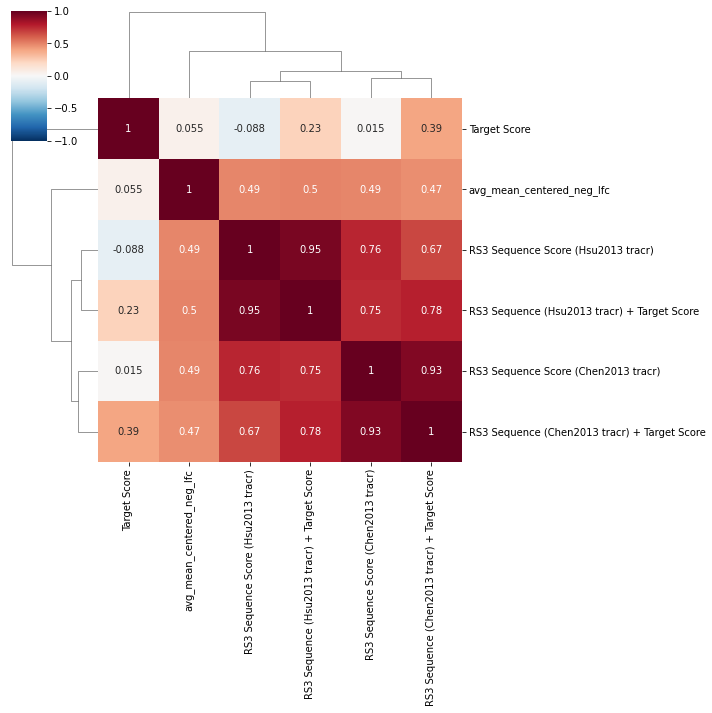

In [ ]:
gecko_activity_cors = gecko_activity_scores[[activity_col] + score_cols].corr()
sns.clustermap(gecko_activity_cors, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)

In [ ]:
assert (gecko_activity_cors.loc[activity_col, 'RS3 Sequence (Hsu2013 tracr) + Target Score'] >
        gecko_activity_cors.loc[activity_col, 'RS3 Sequence Score (Hsu2013 tracr)'] >
        gecko_activity_cors.loc[activity_col, 'RS3 Sequence Score (Chen2013 tracr)'] >
        gecko_activity_cors.loc[activity_col, 'RS3 Sequence (Chen2013 tracr) + Target Score'] >
        gecko_activity_cors.loc[activity_col, 'Target Score'])